# Tensorflow Exercise

Multi-class classification on Stack Overflow questions

In [2]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses

In [9]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz'
dataset = tf.keras.utils.get_file(origin=url, untar=True, cache_dir=".", cache_subdir='')
dataset_dir = os.path.join(os.path.dirname(dataset), 'stack_overflow_16k')
print(dataset_dir)

6053168/6053168 [==============================] - 0s 0us/step
.\stack_overflow_16k


In [27]:
batch_size = 32
seed = 42

train_dir = 'train'

raw_train_ds = tf.keras.utils.text_dataset_from_directory(train_dir, batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

print(type(raw_train_ds))

Found 8000 files belonging to 4 classes.
Using 6400 files for training.
<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


In [28]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Question: \n", text_batch.numpy()[i])
    print("Label: ", label_batch.numpy()[i])

Question: 
 b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default co

In [29]:
for i in range(len(raw_train_ds.class_names)):
    print(f'Label {i} corresponds to: {raw_train_ds.class_names[i]}')

Label 0 corresponds to: csharp
Label 1 corresponds to: java
Label 2 corresponds to: javascript
Label 3 corresponds to: python


In [30]:
# Create raw test and validation sets

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    directory='train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    directory='test',
    batch_size=batch_size
)


Found 8000 files belonging to 4 classes.
Using 1600 files for validation.
Found 8000 files belonging to 4 classes.


In [37]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [38]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  saw
 313 --->  source
Vocabulary size: 10000


In [40]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create the model

In [53]:
embedding_dim = 16

model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(4)])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout_2 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
Total params: 160,084
Trainable params: 160,084
Non-trainable params: 0
________________________________________________

In [69]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

In [70]:
epochs = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
200/200 [==============================] - 1s 5ms/step - loss: 1.3770 - accuracy: 0.3531 - val_loss: 1.3650 - val_accuracy: 0.4569
Epoch 2/10
200/200 [==============================] - 1s 5ms/step - loss: 1.3470 - accuracy: 0.4661 - val_loss: 1.3252 - val_accuracy: 0.5281
Epoch 3/10
200/200 [==============================] - 1s 4ms/step - loss: 1.2953 - accuracy: 0.5306 - val_loss: 1.2657 - val_accuracy: 0.5738
Epoch 4/10
200/200 [==============================] - 1s 5ms/step - loss: 1.2272 - accuracy: 0.5814 - val_loss: 1.1928 - val_accuracy: 0.6131
Epoch 5/10
200/200 [==============================] - 1s 4ms/step - loss: 1.1508 - accuracy: 0.6331 - val_loss: 1.1179 - val_accuracy: 0.6550
Epoch 6/10
200/200 [==============================] - 1s 5ms/step - loss: 1.0747 - accuracy: 0.6728 - val_loss: 1.0469 - val_accuracy: 0.6900
Epoch 7/10
200/200 [==============================] - 1s 4ms/step - loss: 1.0055 - accuracy: 0.7069 - val_loss: 0.9827 - val_accuracy: 0.7113
Epoch 

In [71]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 0s 1ms/step - loss: 0.8670 - accuracy: 0.7295
Loss:  0.8670276999473572
Accuracy:  0.7294999957084656


In [72]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

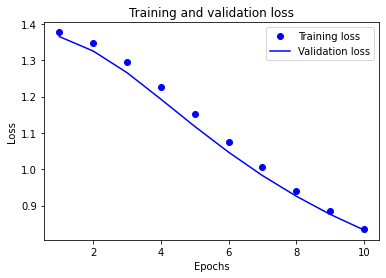

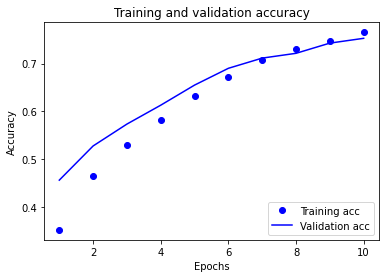

In [73]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()